# `CLOUD.jl` - 2D linear advection example

In [17]:
using CLOUD, OrdinaryDiffEq, Plots, Plots.PlotMeasures

## Define the physical problem

In [18]:
θ = π/4 # wave angle
a = sqrt(2) # wave speed
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(sin(θ)))) # end time for one period

conservation_law = LinearAdvectionEquation((a*cos(θ),a*sin(θ)))
initial_data = InitialDataSine(A,k)
exact_solution = ExactSolution(conservation_law,initial_data);

## Set discretization parameters (energy-conservative scheme)

In [19]:
M = 4
p = 4
form = WeakConservationForm(mapping_form=SkewSymmetricMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux(0.0))

ode_algorithm = CarpenterKennedy2N54()
dt = 0.25*(L/M)/(a*(2*p+1))
write_interval = floor(Int, T/(dt*10));

## Set up a `NodalTensor` scheme on quadrilaterals of degree `p` with `M` edges in each direction

In [20]:
reference_approximation = ReferenceApproximation(
    NodalTensor(p), Quad(), mapping_degree=p)

mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M)), 
    reference_approximation.reference_element, 0.2)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T),
    "results/advection_2d/", overwrite=true, clear=true);

## Run the solver

In [21]:
ode_problem_1 = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T))

CLOUD_reset_timer!()
sol = solve(ode_problem_1, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, (0.0,T), write_interval))
CLOUD_print_timer()

 ────────────────────────────────────────────────────────────────────────────────
            Thread 1                    Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            460ms /  93.8%            195MiB /  93.9%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 local residual         16.5k    426ms   98.8%  25.8μs    179MiB   97.5%  11.1KiB
   apply operators      16.5k    113ms   26.1%  6.82μs    127MiB   69.1%  7.84KiB
     volume terms       16.5k   70.9ms   16.4%  4.29μs    102MiB   55.9%  6.34KiB
     facet terms        16.5k   5.01ms    1.2%   303ns   3.53MiB    1.9%     224B
     mul test function  16.5k   3.42ms    0.8%   207ns    516KiB    0.3%    32.0B
     mass matrix solve  16.5k   2.07ms    0.5%   125ns     0.00B    0.0%    0.00B
   eval num flu

## Calculate the integral L<sup>2</sup> error norm

In [22]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), initial_data, T)...)

L2 error:
0.07575407088358414


## Analyze conservation and energy dissipation

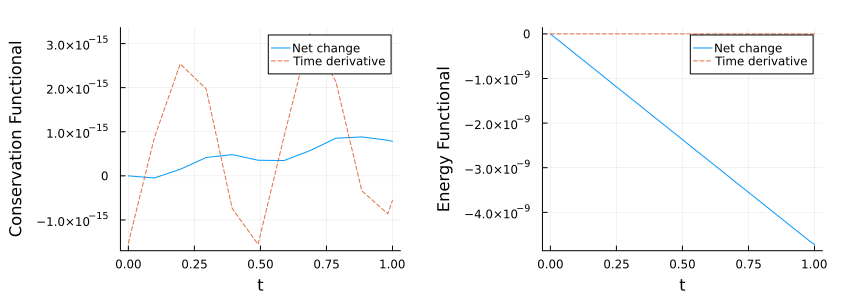

In [23]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), ylabel="Conservation Functional");
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), ylabel="Energy Functional");
plot(p1,p2, size=(850,300),margin=5mm)

## Postprocess for VTK visualization

In [24]:
postprocess_vtk(spatial_discretization, string(results_path,"solution.vtu"), last(sol.u));